In [1]:
"""
This is the only script that requires a unique (old xr version) conda environment. Modern Xarray cant seem to open the NPP files. Sorry.  So yeah I have the environment Pacific_carbon that works. see the git repo. 
Otherwise idk good luck. 

This file is used to download NPP Satellite Data / Algorithms from the Oregon State Website. It then Processes them into usable Netcdf files by modern versions of xarray.

YOU NEED TO USE XR.__version<=0.15.1 

"""

'\nThis is the only script that requires a unique (old xr version) conda environment. Modern Xarray cant seem to open the NPP files. Sorry.  So yeah I have the environment Pacific_carbon that works. see the git repo. \nOtherwise idk good luck. \n\nThis file is used to download NPP Satellite Data / Algorithms from the Oregon State Website. It then Processes them into usable Netcdf files by modern versions of xarray.\n\nYOU NEED TO USE XR.__version<=0.15.1 \n\n'

In [2]:
#Unique compared to the other set of scripts in this repo.
import requests                      #Version '2.19.1'
import xarray as xr                  #Version '0.11.3'
import numpy as np                   #Version '1.16.1' (Not used here, but in chl_tpca_algorithms)
import matplotlib.pyplot as plt      #Version '3.0.0'
import os
from bs4 import BeautifulSoup
import multiprocessing
import sys
import pandas as pd
from tarfile import TarFile
import gzip
import subprocess
import calendar
import shutil

In [3]:
xr.__version__ # Cant guarantee this will work with versions > 0.15.1 

'0.15.1'

In [4]:
# Easily Changable Initial Parameters
working_dir='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/'
output_directory='datasets/npp_satellite/' #Where we will save the data
dask_enabled=True
plot=True

os.chdir(working_dir)
from downloader import unzip_extract_convert, downloader, gzipper
#datasets=['mod_cafe','viirs_vgpm','viirs_eppley','viirs_cbpm','sw_cbpm','sw_cafe',
datasets=['sw_vgbm','sw_eppley','mod_vgpm','mod_eppley','mod_cbpm'] # These are listed below. 



In [5]:
# We need to load lots of files (URL) in: 

In [6]:
sensor,ppname,viirs_cbpm='viirs','cbpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2020.tar']

In [7]:
sensor,ppname,viirs_eppley='viirs','eppley',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2014.tar',        
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2021.tar']

In [8]:
sensor,ppname,viirs_vgpm='viirs','vgpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2021.tar']

In [9]:
sensor,ppname,sw_cbpm='sw','cbpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2010.tar']

In [10]:
sensor,ppname,sw_vgbm='sw','vbpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2009.tar']

In [11]:
sensor,ppname,sw_eppley='sw','eppley',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2009.tar']

In [12]:
sensor,ppname,mod_vgpm='mod','vgpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2021.tar']

In [13]:
sensor,ppname,mod_eppley='mod','eppley',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2021.tar']

In [14]:
sensor,ppname,mod_cbpm='mod','cbpm',[        
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2021.tar']

In [15]:
sensor,ppname,mod_cafe='mod','cafe',[        
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2021.tar']

In [16]:
sensor,ppname,sw_cafe='sw','cafe',[        
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2009.tar']

In [17]:
if dask_enabled==True:
    # Set up a remote dask cluster if desired
    from dask.distributed import Client,Scheduler
    from dask_jobqueue import SLURMCluster
    cluster = SLURMCluster(cores=2,memory="16GB")
    client = Client(cluster)
    cluster.scale(cores=8)
    #cluster.adapt(minimum=2, maximum=16)
    client

/short/v45/np1383/conda/envs/pacific_carbon/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40729 instead
  http_address["port"], self.http_server.port


In [18]:
cluster

SLURMCluster('tcp://10.0.128.130:33667', workers=0, threads=0, memory=0 B)

Starting on: sw / vgbm
Creating directory:  datasets/npp_satellite/vgbm_sw_extracted
Creating directory:  datasets/npp_satellite/vgbm_sw_opened
Creating directory:  datasets/npp_satellite/vgbm_sw_converted
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1997.tar
Exists:  datasets/npp_satellite/vgbm_sw/vgpm.s.1997.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1998.tar
Exists:  datasets/npp_satellite/vgbm_sw/vgpm.s.1998.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1999.tar
Exists:  datasets/npp_satellite/vgbm_sw/vgpm.s.1999.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2000.tar
Exists:  datasets/npp_satellite/vgbm_sw/vgpm.s.2000.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2001.tar
Exists:  datasets/npp_satellite/vgbm_sw/vgpm.s.2001.tar
http://orca.science.oregonstate.edu/data/1x2/8day

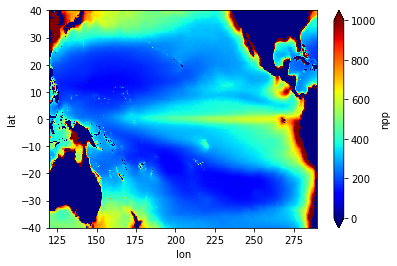

Starting on: sw / eppley
Creating directory:  datasets/npp_satellite/eppley_sw_extracted
Creating directory:  datasets/npp_satellite/eppley_sw_opened
Creating directory:  datasets/npp_satellite/eppley_sw_converted
Creating directory:  datasets/npp_satellite/eppley_sw_nc
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1997.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.1997.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1998.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.1998.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1999.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.1999.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2000.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.2000.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2001.tar
Exis

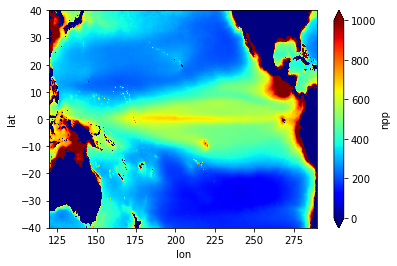

Starting on: mod / vgpm
Creating directory:  datasets/npp_satellite/vgpm_mod_extracted
Creating directory:  datasets/npp_satellite/vgpm_mod_opened
Creating directory:  datasets/npp_satellite/vgpm_mod_converted
Creating directory:  datasets/npp_satellite/vgpm_mod_nc
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2002.tar
Exists:  datasets/npp_satellite/vgpm_mod/vgpm.m.2002.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2003.tar
Exists:  datasets/npp_satellite/vgpm_mod/vgpm.m.2003.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2004.tar
Exists:  datasets/npp_satellite/vgpm_mod/vgpm.m.2004.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2005.tar
Exists:  datasets/npp_satellite/vgpm_mod/vgpm.m.2005.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2006.tar
Exists:  datasets/npp_satellite/vgpm_mod/

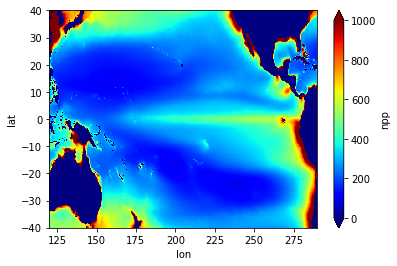

Starting on: mod / eppley
Creating directory:  datasets/npp_satellite/eppley_mod_extracted
Creating directory:  datasets/npp_satellite/eppley_mod_opened
Creating directory:  datasets/npp_satellite/eppley_mod_converted
Creating directory:  datasets/npp_satellite/eppley_mod_nc
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2002.tar
Exists:  datasets/npp_satellite/eppley_mod/eppley.m.2002.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2003.tar
Exists:  datasets/npp_satellite/eppley_mod/eppley.m.2003.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2004.tar
Exists:  datasets/npp_satellite/eppley_mod/eppley.m.2004.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2005.tar
Exists:  datasets/npp_satellite/eppley_mod/eppley.m.2005.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2006

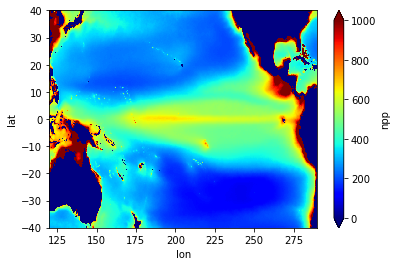

Starting on: mod / cbpm
Creating directory:  datasets/npp_satellite/cbpm_mod_extracted
Creating directory:  datasets/npp_satellite/cbpm_mod_opened
Creating directory:  datasets/npp_satellite/cbpm_mod_converted
Creating directory:  datasets/npp_satellite/cbpm_mod_nc
http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2002.tar
Exists:  datasets/npp_satellite/cbpm_mod/cbpm.m.2002.tar
http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2003.tar
Exists:  datasets/npp_satellite/cbpm_mod/cbpm.m.2003.tar
http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2004.tar
Exists:  datasets/npp_satellite/cbpm_mod/cbpm.m.2004.tar
http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2005.tar
Exists:  datasets/npp_satellite/cbpm_mod/cbpm.m.2005.tar
http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2006.tar
Exists:  datasets/npp_satellite/cbpm_mod/cbpm.m.2006.tar
http://or

KeyboardInterrupt: 

In [19]:
for s in datasets:
    sensor,ppname=s.split('_')
    print('Starting on: '+sensor+' / ' +ppname)
    dat=downloader(eval(s),sensor=sensor,ppname=ppname)
    unzip_extract_convert(sensor=sensor,ppname=ppname)
    
    #PROVE IT OPENS!   
    
    print('Opening File.')
    data=xr.open_mfdataset(output_directory+ppname+'_'+sensor+'_nc/*nc',concat_dim='time',combine='nested')
    if plot==True:
        print('Plotting mean map....')
        data.mean(dim='time').npp.plot(cmap='jet',vmin=0,vmax=1000)
        plt.show()

OTHER PRODUCTS COULD INCLUDE

https://e4ftl01.cr.usgs.gov/MOLA/MYD17A2H.006/
https://lpdaac.usgs.gov/products/myd17a2hv006/    